# Affinity Propagation

모든 데이터가 특정한 기준에 따라 자신을 대표할 대표 데이터를 선택한다. 만약 스스로가 자기 자신을 대표하게 되면 클러스터의 중심이 된다.

* responsibility $r(i, k)$

    * $k$번째 데이터가 $i$번째 데이터의 대표가 되어야 한다는 근거


* availability $a(i, k)$

    * $i$번째 데이터가 $k$번째 데이터를 대표로 선택해야 한다는 근거
    
    
* 다음 수식을 수렴할 때까지 반복

$$ r(i, k) \leftarrow s(i, k) - \max_{k' \neq k} ( a(i, k') + s(i, k')) $$

$$ a(i, k) \leftarrow \min(0, r(k, k) + \sum_{i' \neq i,k} r(i', k)) $$

여기에서 $s(i,k)$는 다음과 같이 음의 거리로 정의되는 유사도이다.

$$ s(i,k) = -|| x_i - x_k ||^2 $$

특히 $s(k,k)$는 특정한 음수 값으로 사용자가 정해 주게 되는데 이 값에 따라서 클러스터의 갯수가 달라지는 하이퍼 모수가 된다. $s(k,k)$가 크면 자기 자신에 대한 유사도가 커져서 클러스터의 수가 증가한다.

위 알고리즘으로 계산하는 $r$, $a$가 더 이상 변화하지 않고 수렴하면 계산이 종료되고 종료 시점에서 $r(k,k) + a(k,k) > 0$이 데이터가 클러스터의 중심이 된다.

### 예 1

* http://scikit-learn.org/stable/auto_examples/cluster/plot_affinity_propagation.html

In [1]:
##스타트업 파일

from scipy.stats import norm
import numpy as np
import scipy as sp
from pandas.core import datetools 
import pandas as pd
import statsmodels.api as sm ## R 패키지에서 불러온것, 샘플데이터 옮겨쓸수 있는 프로젝트 있음. 회귀분석에 유용 
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk 
## 전처리 

import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pylab 
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  


In [2]:
from sklearn.datasets.samples_generator import make_blobs

centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=300, centers=centers, cluster_std=0.5, random_state=0)

In [3]:
from sklearn.cluster import AffinityPropagation

model = AffinityPropagation(preference=-50).fit(X)

In [4]:
cluster_centers_indices = model.cluster_centers_indices_
labels = model.labels_
n_clusters_ = len(cluster_centers_indices)

from sklearn import metrics

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

Estimated number of clusters: 3
Homogeneity: 0.872
Completeness: 0.872
V-measure: 0.872
Adjusted Rand Index: 0.912
Adjusted Mutual Information: 0.871
Silhouette Coefficient: 0.753


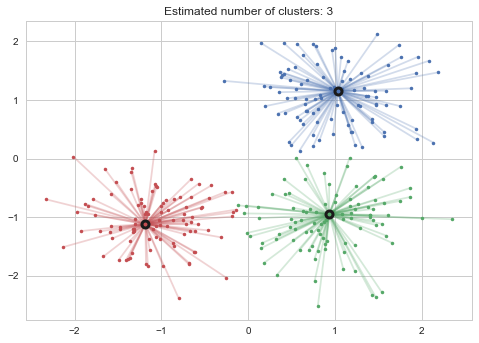

In [5]:
from itertools import cycle

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col, alpha=0.25)
    plt.plot(cluster_center[0], cluster_center[1], 'o', mec='k', mew=3, markersize=7)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

### 예 2:

* http://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html

In [9]:

from datetime import datetime

from matplotlib.collections import LineCollection
from six.moves.urllib.request import urlopen
from six.moves.urllib.parse import urlencode
from sklearn import cluster, covariance, manifold


def quotes_historical_google(symbol, date1, date2):
    """Get the historical data from Google finance.

    Parameters
    ----------
    symbol : str
        Ticker symbol to query for, for example ``"DELL"``.
    date1 : datetime.datetime
        Start date.
    date2 : datetime.datetime
        End date.

    Returns
    -------
    X : array
        The columns are ``date`` -- datetime, ``open``, ``high``,
        ``low``, ``close`` and ``volume`` of type float.
    """
    params = urlencode({
        'q': symbol,
        'startdate': date1.strftime('%b %d, %Y'),
        'enddate': date2.strftime('%b %d, %Y'),
        'output': 'csv'
    })
    url = 'http://www.google.com/finance/historical?' + params
    response = urlopen(url)
    dtype = {
        'names': ['date', 'open', 'high', 'low', 'close', 'volume'],
        'formats': ['object', 'f4', 'f4', 'f4', 'f4', 'f4']
    }
    converters = {0: lambda s: datetime.strptime(s.decode(), '%d-%b-%y')}
    return np.genfromtxt(response, delimiter=',', skip_header=1,
                         dtype=dtype, converters=converters,
                         missing_values='-', filling_values=-1)


# Choose a time period reasonably calm (not too long ago so that we get
# high-tech firms, and before the 2008 crash)
d1 = datetime(2003, 1, 1)
d2 = datetime(2008, 1, 1)

symbol_dict = {
    'TOT': 'Total',
    'XOM': 'Exxon',
    'CVX': 'Chevron',
    'COP': 'ConocoPhillips',
    'VLO': 'Valero Energy',
    'MSFT': 'Microsoft',
    'IBM': 'IBM',
    'TWX': 'Time Warner',
    'CMCSA': 'Comcast',
    'CVC': 'Cablevision',
    'YHOO': 'Yahoo',
    'DELL': 'Dell',
    'HPQ': 'HP',
    'AMZN': 'Amazon',
    'TM': 'Toyota',
    'CAJ': 'Canon',
    'SNE': 'Sony',
    'F': 'Ford',
    'HMC': 'Honda',
    'NAV': 'Navistar',
    'NOC': 'Northrop Grumman',
    'BA': 'Boeing',
    'KO': 'Coca Cola',
    'MMM': '3M',
    'MCD': 'McDonald\'s',
    'PEP': 'Pepsi',
    'K': 'Kellogg',
    'UN': 'Unilever',
    'MAR': 'Marriott',
    'PG': 'Procter Gamble',
    'CL': 'Colgate-Palmolive',
    'GE': 'General Electrics',
    'WFC': 'Wells Fargo',
    'JPM': 'JPMorgan Chase',
    'AIG': 'AIG',
    'AXP': 'American express',
    'BAC': 'Bank of America',
    'GS': 'Goldman Sachs',
    'AAPL': 'Apple',
    'SAP': 'SAP',
    'CSCO': 'Cisco',
    'TXN': 'Texas Instruments',
    'XRX': 'Xerox',
    'WMT': 'Wal-Mart',
    'HD': 'Home Depot',
    'GSK': 'GlaxoSmithKline',
    'PFE': 'Pfizer',
    'SNY': 'Sanofi-Aventis',
    'NVS': 'Novartis',
    'KMB': 'Kimberly-Clark',
    'R': 'Ryder',
    'GD': 'General Dynamics',
    'RTN': 'Raytheon',
    'CVS': 'CVS',
    'CAT': 'Caterpillar',
    'DD': 'DuPont de Nemours'}

symbols, names = np.array(list(symbol_dict.items())).T

quotes = [
    quotes_historical_google(symbol, d1, d2) for symbol in symbols
]

close_prices = np.vstack([q['close'] for q in quotes])
open_prices = np.vstack([q['open'] for q in quotes])

# The daily variations of the quotes are what carry most information
variation = close_prices - open_prices

edge_model = covariance.GraphLassoCV()

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = variation.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()

for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: UserWarning: genfromtxt: Empty input file: "<http.client.HTTPResponse object at 0x0000023FE540CEB8>"


IndexError: list index out of range

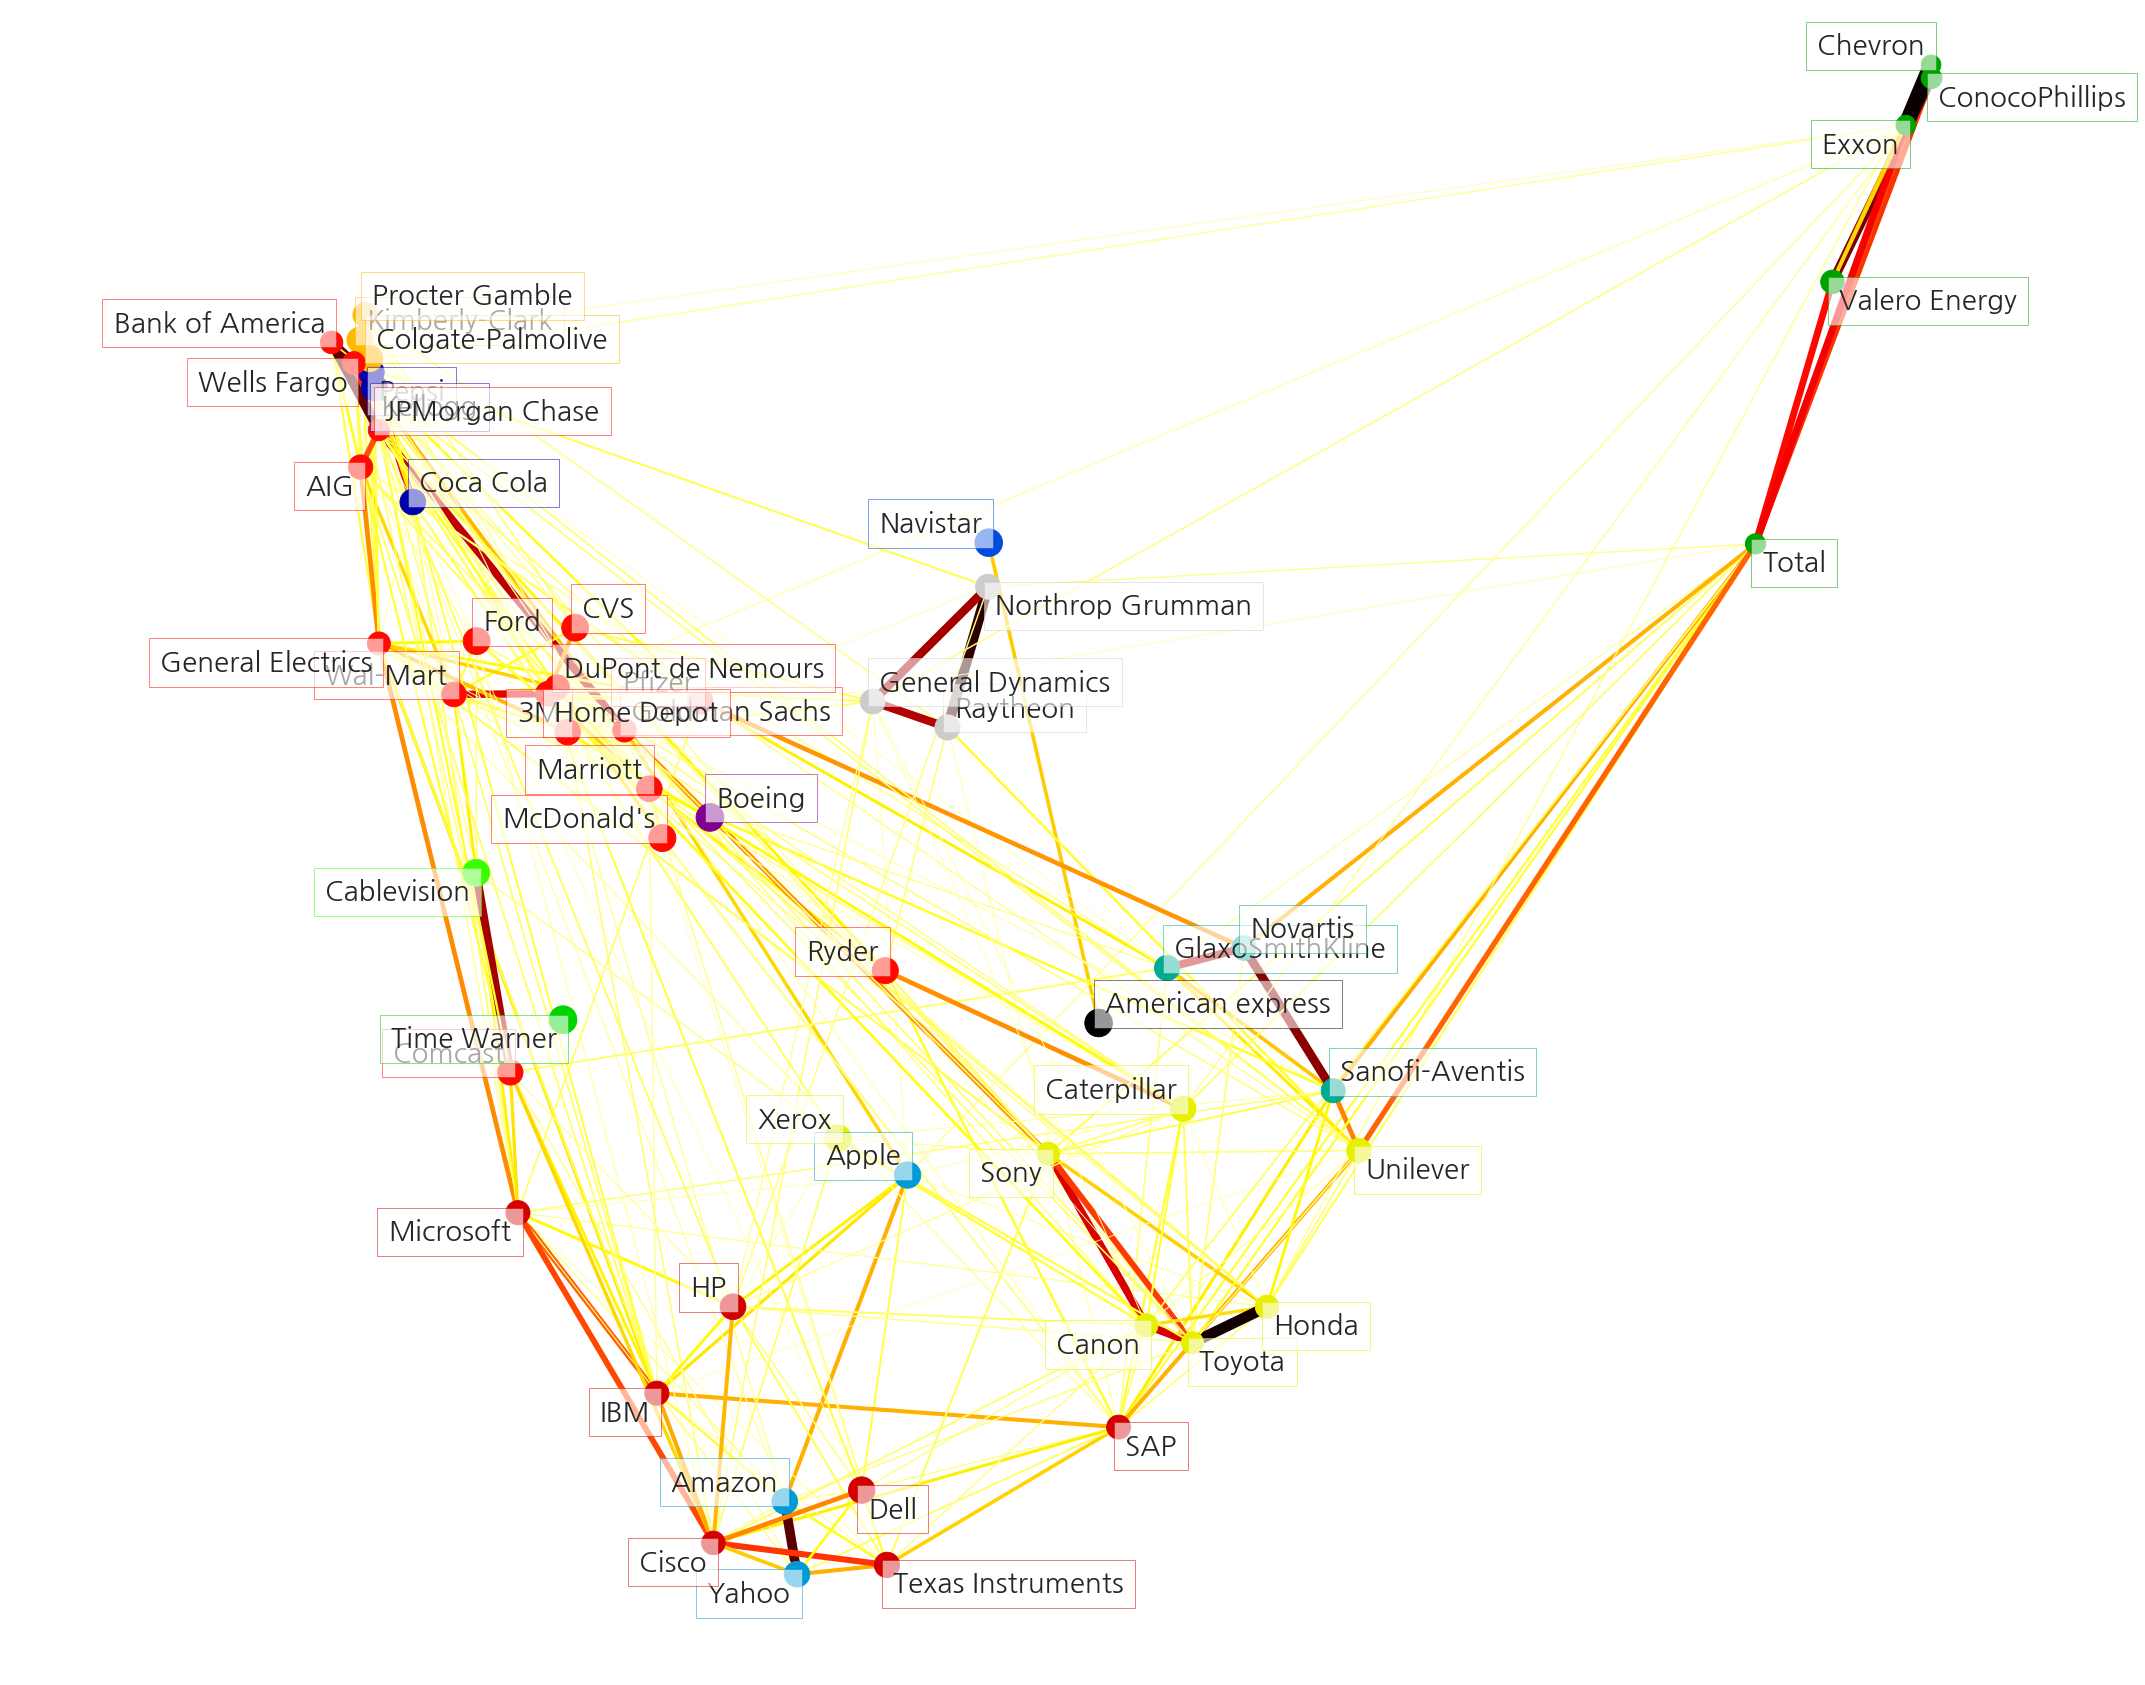

In [6]:
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(X.T).T

plt.figure(1, facecolor='w', figsize=(10, 8))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.spectral)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.spectral(label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()